In [35]:
import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt

In [36]:
od_matrix = pd.read_csv('../data/algo_testing_data.csv')
od_matrix

,Year,Origin,Dest,NonStopKm,Passengers,city_origin,state_origin,pop_origin,city_dest,state_dest,pop_dest,construction_cost_usd,hsr_time_hr,flight_time_hr,co2_g_flight,co2_g_hsr
0,2022,ABE,ABI,2346.41772,80.0,Allentown,PA,122122,Abilene,TX,122413,4.476554e+09,11.732089,3.352025,2.496588e+07,4.505122e+06
1,2022,ATY,ABI,1404.95382,10.0,Watertown,SD,22621,Abilene,TX,122413,2.680406e+09,7.024769,2.341590,1.868589e+06,3.371889e+05
2,2022,CVN,ABI,386.24160,10.0,Clovis,NM,40780,Abilene,TX,122413,7.368814e+08,1.931208,0.965604,5.137013e+05,9.269798e+04
3,2022,EAT,ABI,2404.35396,10.0,Wenatchee,WA,33687,Abilene,TX,122413,4.587087e+09,12.021770,3.434791,3.197791e+06,5.770450e+05
4,2022,ELD,ABI,650.17336,10.0,El Dorado,AR,18551,Abilene,TX,122413,1.240417e+09,3.250867,1.625433,8.647306e+05,1.560416e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31054,2022,SFB,USA,735.46838,61810.0,Orlando,FL,283852,Concord,NC,91091,1.403145e+09,3.677342,1.838671,6.046087e+09,1.091023e+09
31055,2022,LAS,SCK,577.75306,117500.0,Las Vegas,NV,642798,Stockton,CA,312272,1.102252e+09,2.888765,1.444383,9.028836e+09,1.629264e+09
31056,2022,PHX,SCK,970.43202,29350.0,Phoenix,AZ,1601381,Stockton,CA,312272,1.851414e+09,4.852160,1.617387,3.788130e+09,6.835723e+08
31057,2022,MSP,MKT,91.73238,10.0,Minneapolis,MN,415852,Mankato,MN,41526,1.750093e+08,0.458662,0.458662,1.220041e+05,2.201577e+04


In [37]:
cities_geom = gpd.read_file('../data/us-major-cities/USA_Major_Cities.shp')
og_crs = cities_geom.crs
cols_of_interest = [
    'NAME', # name of city
    'CLASS', # city, town, etc
    'ST', # state code
    'POPULATION',
    'geometry' # Point
]
cities_geom = cities_geom[cols_of_interest]
# drop AK and HI
cities_geom = cities_geom[(cities_geom['ST'] != 'AK') & (cities_geom['ST'] != 'HI')]
cities_geom

,NAME,CLASS,ST,POPULATION,geometry
0,Ammon,city,ID,15181,POINT (-111.95410 43.47579)
1,Blackfoot,city,ID,11946,POINT (-112.34557 43.19394)
2,Boise City,city,ID,225405,POINT (-116.23011 43.59901)
3,Burley,city,ID,10727,POINT (-113.79329 42.53674)
4,Caldwell,city,ID,53942,POINT (-116.68562 43.66163)
...,...,...,...,...,...
3881,Herndon,town,VA,23993,POINT (-77.38672 38.96993)
3882,Highland Springs,Census Designated Place,VA,16618,POINT (-77.32854 37.55172)
3883,Hollins,Census Designated Place,VA,15033,POINT (-79.95348 37.34338)
3884,Hopewell,city,VA,22935,POINT (-77.29837 37.29038)


In [38]:
# merge route data with geographic data from shapefile
# all flight routes for which we have volume data from db1b
routes = od_matrix.copy()
cols = [
    'Origin',
    'Dest',
    'NonStopKm',
    'Passengers',
    'city_origin',
    'state_origin',
    'city_dest',
    'state_dest',
    'construction_cost_usd',
    'hsr_time_hr',
    'flight_time_hr',
    'co2_g_flight',
    'co2_g_hsr'
]
geom_cols = [
    'NAME',
    'ST',
    'geometry',
]
routes = routes[cols]\
    .merge(cities_geom[geom_cols], how='inner', left_on=['city_origin', 'state_origin'], right_on=['NAME', 'ST'])\
    .rename(columns={'geometry': 'pt_origin'})\
    .drop(columns=['NAME', 'ST'])\
    .merge(cities_geom[geom_cols], how='inner', left_on=['city_dest', 'state_dest'], right_on=['NAME', 'ST'])\
    .rename(columns={'geometry': 'pt_dest'})\
    .drop(columns=['NAME', 'ST'])
    
segments = routes.apply(lambda row: shapely.LineString((row['pt_origin'], row['pt_dest'])), axis='columns')
routes = gpd.GeoDataFrame(routes, geometry=segments, crs=og_crs) # type: ignore
routes

,Origin,Dest,NonStopKm,Passengers,city_origin,state_origin,city_dest,state_dest,construction_cost_usd,hsr_time_hr,flight_time_hr,co2_g_flight,co2_g_hsr,pt_origin,pt_dest,geometry
0,ABE,ABI,2346.41772,80.0,Allentown,PA,Abilene,TX,4.476554e+09,11.732089,3.352025,2.496588e+07,4.505122e+06,POINT (-75.47208 40.59617),POINT (-99.73835 32.45436),"LINESTRING (-75.47208 40.59617, -99.73835 32.4..."
1,ATY,ABI,1404.95382,10.0,Watertown,SD,Abilene,TX,2.680406e+09,7.024769,2.341590,1.868589e+06,3.371889e+05,POINT (-97.10245 44.89959),POINT (-99.73835 32.45436),"LINESTRING (-97.10245 44.89959, -99.73835 32.4..."
2,CVN,ABI,386.24160,10.0,Clovis,NM,Abilene,TX,7.368814e+08,1.931208,0.965604,5.137013e+05,9.269798e+04,POINT (-103.19859 34.40763),POINT (-99.73835 32.45436),"LINESTRING (-103.19859 34.40763, -99.73835 32...."
3,EAT,ABI,2404.35396,10.0,Wenatchee,WA,Abilene,TX,4.587087e+09,12.021770,3.434791,3.197791e+06,5.770450e+05,POINT (-120.32945 47.42575),POINT (-99.73835 32.45436),"LINESTRING (-120.32945 47.42575, -99.73835 32...."
4,ELD,ABI,650.17336,10.0,El Dorado,AR,Abilene,TX,1.240417e+09,3.250867,1.625433,8.647306e+05,1.560416e+05,POINT (-92.66413 33.21824),POINT (-99.73835 32.45436),"LINESTRING (-92.66413 33.21824, -99.73835 32.4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31054,PGD,USA,946.29192,32110.0,Punta Gorda,FL,Concord,NC,1.805359e+09,4.731460,1.577153,4.041263e+09,7.292504e+08,POINT (-82.04773 26.91702),POINT (-80.58179 35.41209),"LINESTRING (-82.04773 26.91702, -80.58179 35.4..."
31055,MSP,MKT,91.73238,10.0,Minneapolis,MN,Mankato,MN,1.750093e+08,0.458662,0.458662,1.220041e+05,2.201577e+04,POINT (-93.26783 44.96352),POINT (-93.98627 44.16131),"LINESTRING (-93.26783 44.96352, -93.98627 44.1..."
31056,DEN,EWB,2835.65708,10.0,Denver,CO,New Bedford,MA,5.409937e+09,14.178285,4.050939,3.771424e+06,6.805577e+05,POINT (-104.98252 39.72937),POINT (-70.93083 41.63674),"LINESTRING (-104.98252 39.72937, -70.93083 41...."
31057,MYR,EWB,1131.36602,10.0,Myrtle Beach,SC,New Bedford,MA,2.158448e+09,5.656830,1.885610,1.504717e+06,2.715278e+05,POINT (-78.88299 33.69640),POINT (-70.93083 41.63674),"LINESTRING (-78.88299 33.69640, -70.93083 41.6..."


In [39]:
states = gpd.read_file('../data/us-states/States_shapefile.shp').to_crs(epsg=3395)
states: gpd.GeoDataFrame = states[(states['State_Code'] != 'AK') & (states['State_Code'] != 'HI')]  # type: ignore


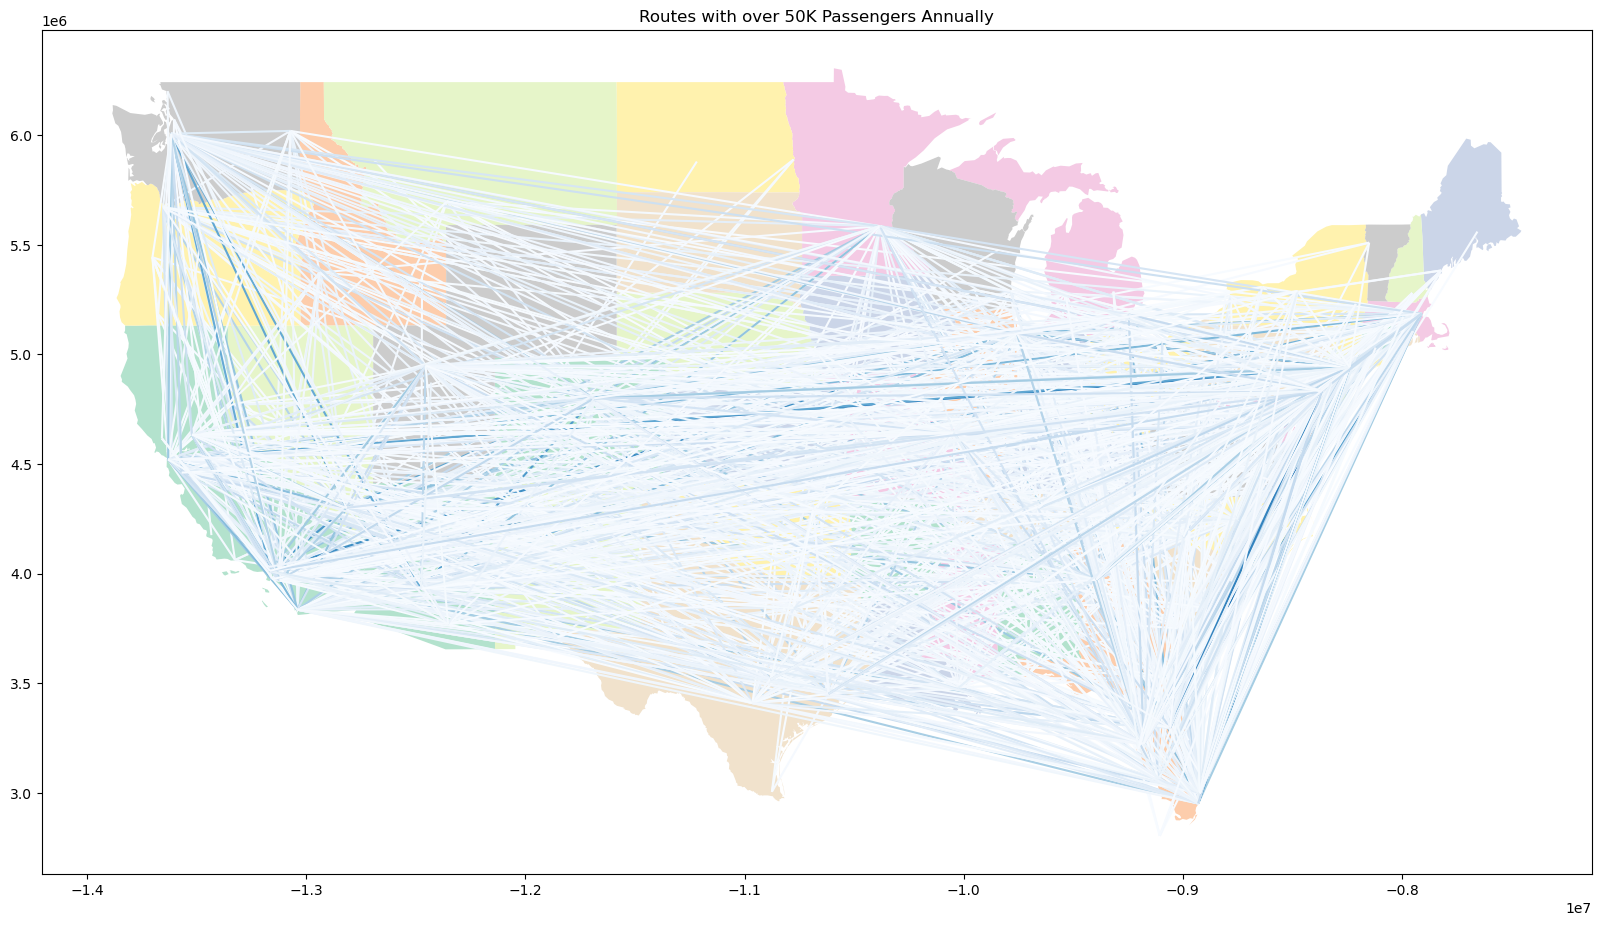

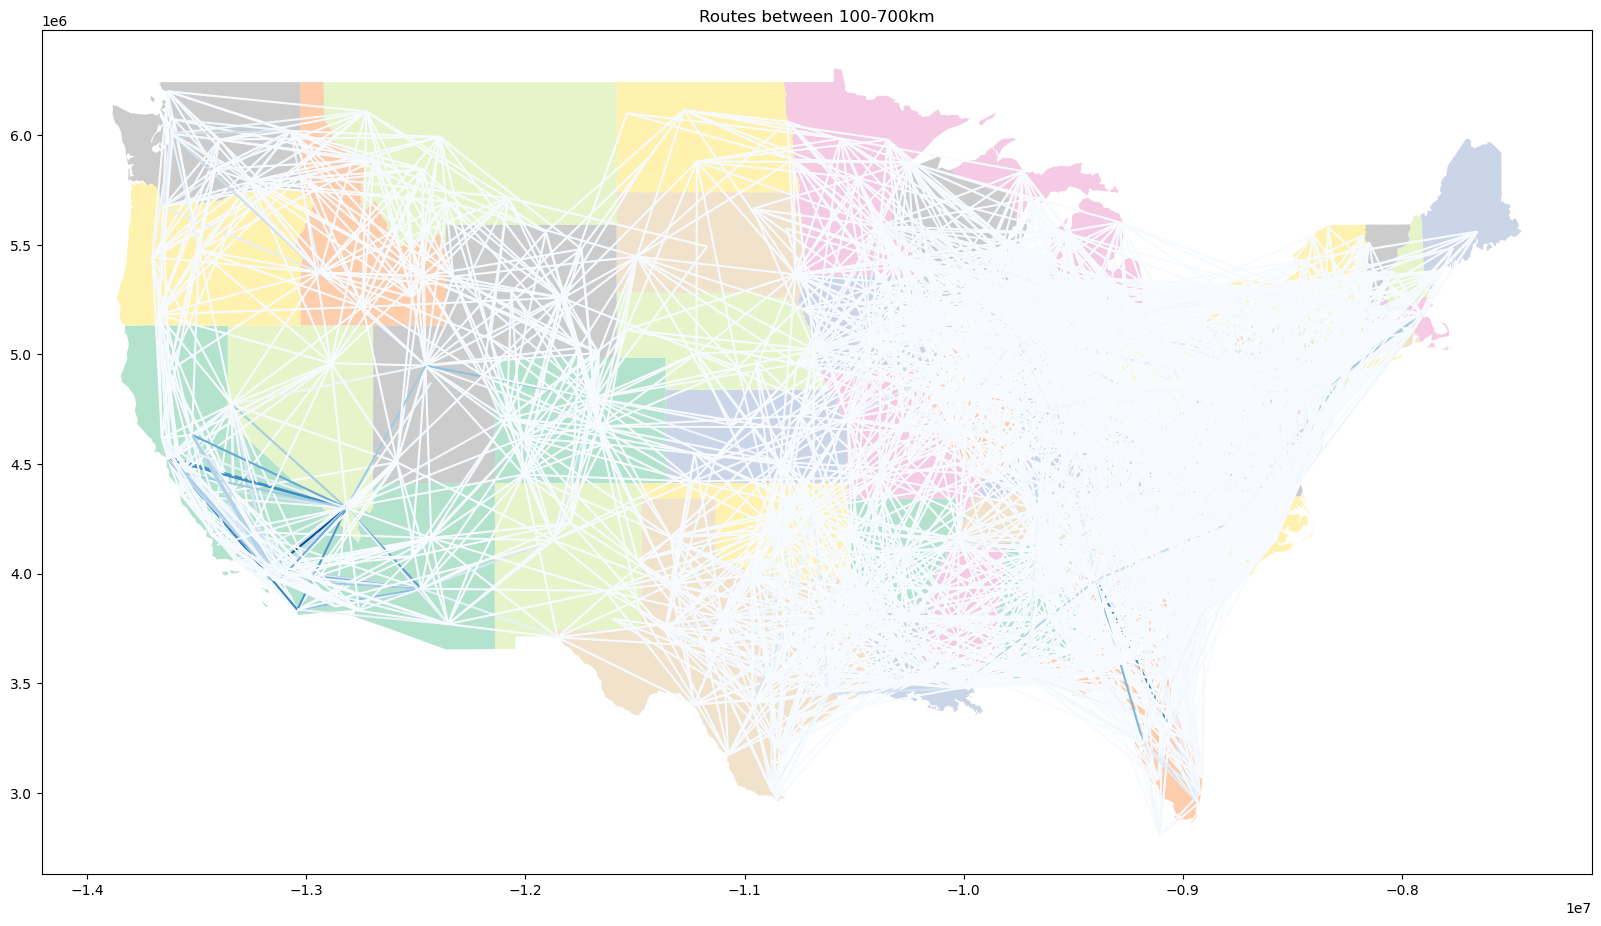

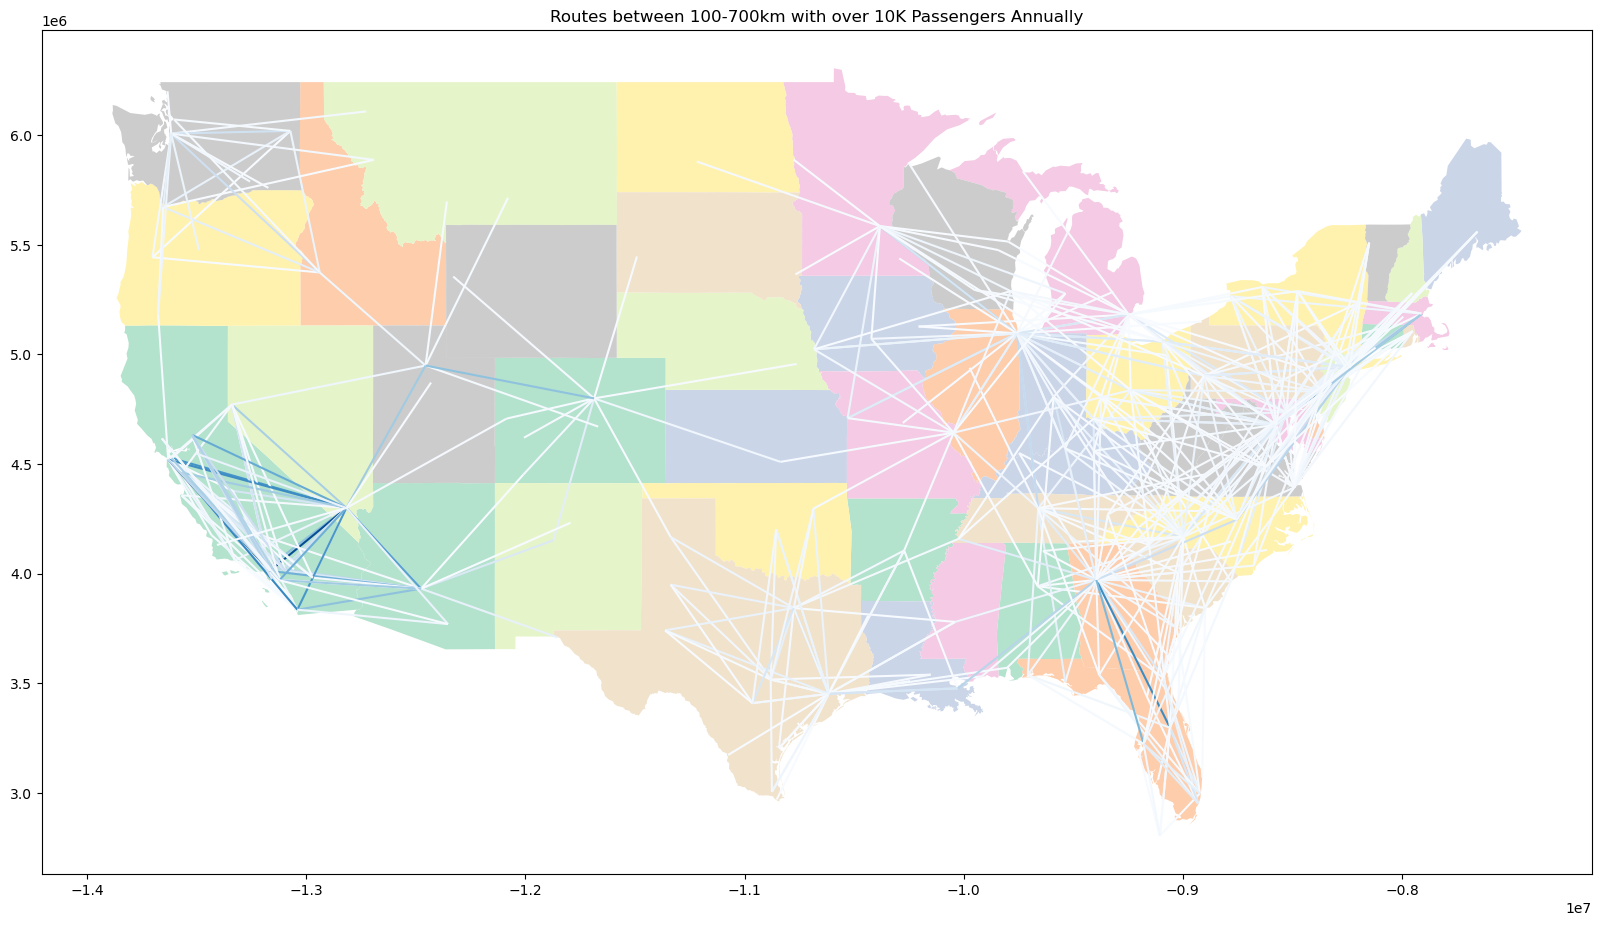

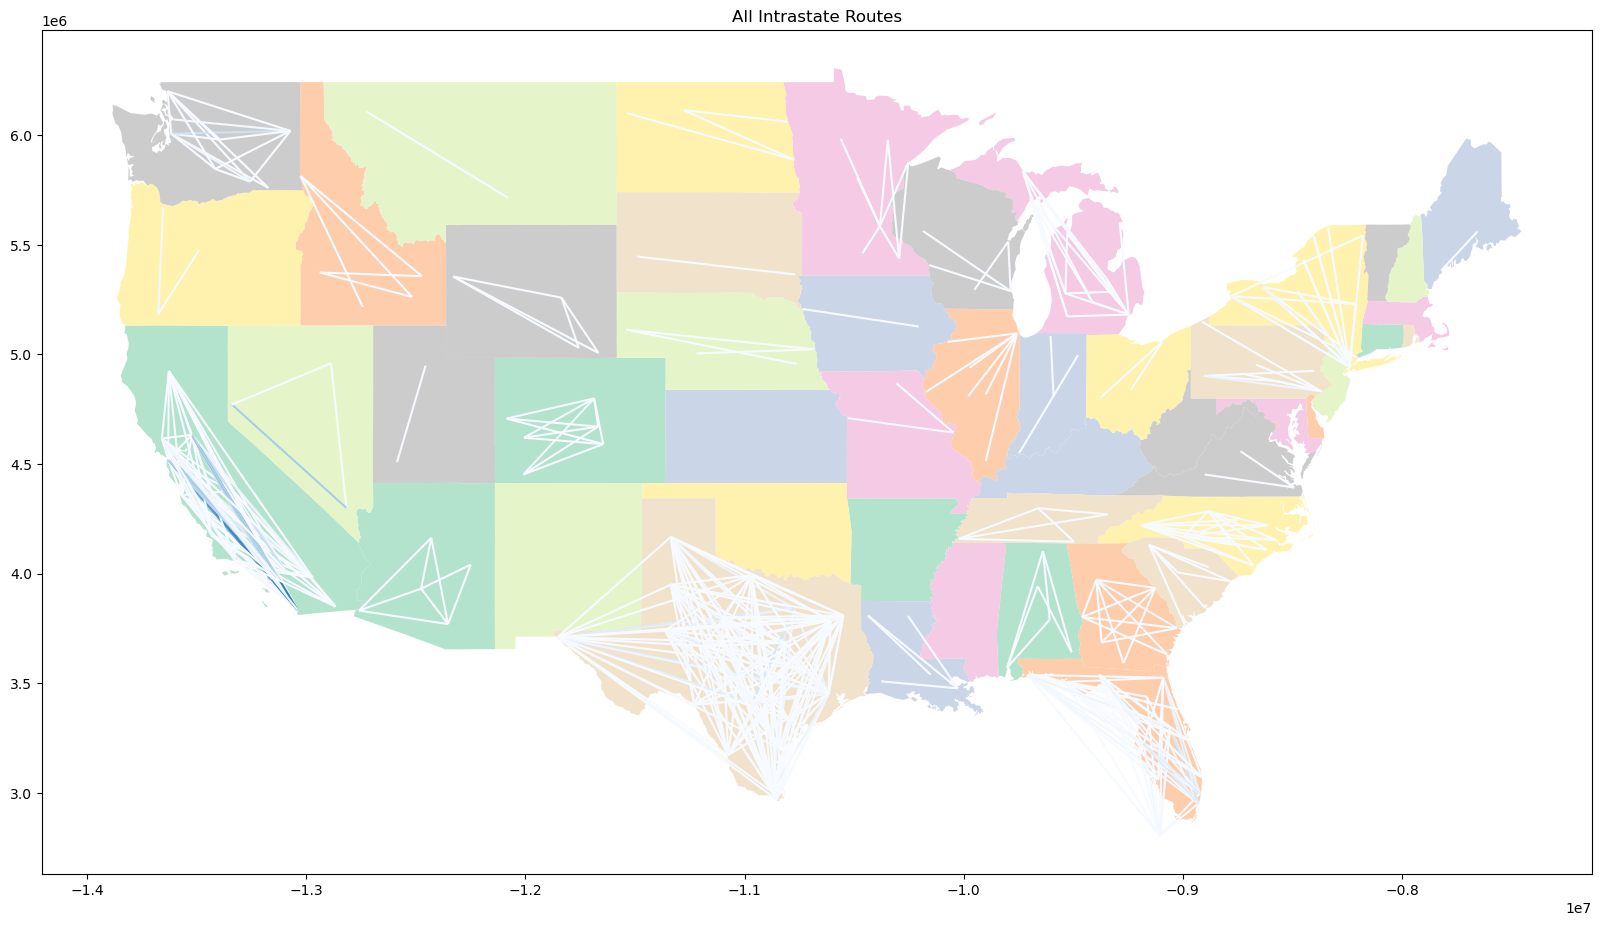

In [77]:
# generate plots
mask = (routes['Passengers'] > 50e3)
masked_routes = routes[mask]
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(20, 20))
ax1 = states.plot(ax=ax1, cmap='Pastel2')
ax1 = masked_routes.to_crs(epsg=3395).plot(ax=ax1, column='Passengers', cmap='Blues') # type: ignore
ax1.set_title('Routes with over 50K Passengers Annually (colored by number of passengers)')
plt.show()

mask = (routes['NonStopKm'] >= 100) & (routes['NonStopKm'] <= 700)
masked_routes = routes[mask]
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(20, 20))
ax1 = states.plot(ax=ax1, cmap='Pastel2')
masked_routes.to_crs(epsg=3395).plot(ax=ax1, column='Passengers', cmap='Blues') # type: ignore
ax1.set_title('Routes between 100-700km (colored by number of passengers)')
plt.show()

mask = (routes['Passengers'] > 10e3) & (routes['NonStopKm'] >= 100) & (routes['NonStopKm'] <= 700)
masked_routes = routes[mask]
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(20, 20))
ax1 = states.plot(ax=ax1, cmap='Pastel2')
masked_routes.to_crs(epsg=3395).plot(ax=ax1, column='Passengers', cmap='Blues') # type: ignore
ax1.set_title('Routes between 100-700km with over 10K Passengers Annually (colored by number of passengers)')
plt.show()

mask = routes['state_origin'] == routes['state_dest']
masked_routes = routes[mask]
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(20, 20))
ax1 = states.plot(ax=ax1, cmap='Pastel2')
masked_routes.to_crs(epsg=3395).plot(ax=ax1, column='Passengers', cmap='Blues') # type: ignore
ax1.set_title('All Intrastate Routes (colored by number of passengers)')
plt.show()